## Regional SAT anomalies calculation then calculate the trend

In [1]:
# In[1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# %%
# define function
import src.SAT_function as data_process
import src.Data_Preprocess as preprocess

In [2]:
# import src.slurm_cluster as scluster
# client, scluster = scluster.init_dask_slurm_cluster(scale=2,cores=10, memory="200GB")

In [3]:
def func_mk(x):
    """
    Mann-Kendall test for trend
    """
    results = data_process.mk_test(x)
    slope = results[0]
    p_val = results[1]
    return slope, p_val

In [4]:
# load data
dir_HadCRUT5 = '/work/mh0033/m301036/Land_surf_temp/Disentangling_OBS_SAT_trend/Supp_Figure1/'
HadCRUT5 = xr.open_dataset(dir_HadCRUT5 + 'tas_HadCRUT5_annual_anomalies_processed.nc')

dir1 ='/work/mh0033/m301036/Land_surf_temp/Disentangling_OBS_SAT_trend/Supplementary/S1/data_revise/'
HadCRUT5_forced = xr.open_mfdataset(dir1 + 'HadCRUT_Forced_signal.nc',chunks={'lat':10,'lon':10})
HadCRUT5_internal = xr.open_mfdataset(dir1 + 'HadCRUT_residual.nc',chunks={'lat':10,'lon':10})

In [5]:
HadCRUT5

<xarray.Dataset> Size: 22MB
Dimensions:                        (year: 173, lat: 90, lon: 180)
Coordinates:
  * year                           (year) int64 1kB 1850 1851 1852 ... 2021 2022
  * lat                            (lat) float64 720B -89.0 -87.0 ... 87.0 89.0
  * lon                            (lon) float64 1kB 0.0 2.0 4.0 ... 356.0 358.0
Data variables:
    __xarray_dataarray_variable__  (year, lat, lon) float64 22MB ...

In [6]:
HadCRUT5 = HadCRUT5.rename({'__xarray_dataarray_variable__':'tas'})
HadCRUT5_forced = HadCRUT5_forced.rename({'__xarray_dataarray_variable__':'tas'})
HadCRUT5_internal = HadCRUT5_internal.rename({'__xarray_dataarray_variable__':'tas'})

In [7]:
HadCRUT5

<xarray.Dataset> Size: 22MB
Dimensions:  (year: 173, lat: 90, lon: 180)
Coordinates:
  * year     (year) int64 1kB 1850 1851 1852 1853 1854 ... 2019 2020 2021 2022
  * lat      (lat) float64 720B -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float64 1kB 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
Data variables:
    tas      (year, lat, lon) float64 22MB ...

### Calculate the trend end year fix to 2022, start with 73 year length and decrease length of trend every one year, the minimum trend length is 10yr 

In [8]:
temp_data = HadCRUT5.tas
temp_data_forced = HadCRUT5_forced.tas
temp_data_internal = HadCRUT5_internal.tas

In [9]:
temp_data

<xarray.DataArray 'tas' (year: 173, lat: 90, lon: 180)> Size: 22MB
[2802600 values with dtype=float64]
Coordinates:
  * year     (year) int64 1kB 1850 1851 1852 1853 1854 ... 2019 2020 2021 2022
  * lat      (lat) float64 720B -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float64 1kB 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0

### Regional anomalies calculation

In [10]:
def plot_trend(temp_data, lats, lons, levels=None, extend=None, cmap=None, 
                                 title="", ax=None, show_xticks=False, show_yticks=False):
    """
    Plot the trend spatial pattern using Robinson projection with significance overlaid.

    Parameters:
    - temp_data: 2D numpy array with the trend values.
    - lats, lons: 1D arrays of latitudes and longitudes.
    - p_values: 2D array with p-values for each grid point.
    - GMST_p_values: 2D array with GMST p-values for each grid point.
    - title: Title for the plot.
    - ax: Existing axis to plot on. If None, a new axis will be created.
    - show_xticks, show_yticks: Boolean flags to show x and y axis ticks.
    
    Returns:
    - contour_obj: The contour object from the plot.
    """
    # Plotting
    contour_obj = ax.contourf(lons, lats, temp_data, levels=levels, extend=extend, cmap=cmap, transform=ccrs.PlateCarree())

    ax.coastlines(resolution='110m')
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,
                      color='gray', alpha=0.35, linestyle='--')

    # Disable labels on the top and right of the plot
    gl.top_labels = False
    gl.right_labels = False

    # Enable labels on the bottom and left of the plot
    gl.bottom_labels = show_xticks
    gl.left_labels = show_yticks
    gl.xformatter = cticker.LongitudeFormatter()
    gl.yformatter = cticker.LatitudeFormatter()
    gl.xlabel_style = {'size': 16}
    gl.ylabel_style = {'size': 16}
    
    if show_xticks:
        gl.bottom_labels = True
    if show_yticks:
        gl.left_labels = True
    
    # ax.set_title(title, loc='center', fontsize=18, pad=5.0)

    return contour_obj
# %%
plt.rcParams['figure.figsize'] = (8, 10)
plt.rcParams['font.size'] = 16
# plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.major.right'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['xtick.bottom'] = True
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.pad_inches'] = 0.1
plt.rcParams['savefig.transparent'] = True

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as mticker
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import seaborn as sns
from matplotlib.colors import ListedColormap
from matplotlib.colors import BoundaryNorm, ListedColormap
import cartopy.util as cutil
import seaborn as sns
import matplotlib.colors as mcolors
import palettable

In [11]:
lat = temp_data.lat
lon = temp_data.lon

In [12]:
# Extratropical South Pacific region
lat1 = -70
lat2 = -55
lon1 = 180
lon2 = 260

In [13]:
temp_data_SOP,lons_SOP, lats_SOP = data_process.selreg(
        temp_data, lat, lon, lat1=lat1, lat2=lat2, lon1=lon1, 
        lon2=lon2)
temp_forced_da_SOP,lons_SOP, lats_SOP = data_process.selreg(
        temp_data_forced, lat, lon, lat1=lat1, lat2=lat2, lon1=lon1, 
        lon2=lon2)

temp_internal_da_SOP,lons_SOP, lats_SOP = data_process.selreg(
        temp_data_internal, lat, lon, lat1=lat1, lat2=lat2, lon1=lon1, 
        lon2=lon2)  

In [14]:
temp_forced_da_SOP_mean = data_process.calc_weighted_mean(temp_forced_da_SOP)
temp_internal_da_SOP_mean = data_process.calc_weighted_mean(temp_internal_da_SOP)

In [15]:
# calculate the SOP region SAT anomalies
temp_da_SOP_mean = data_process.calc_weighted_mean(temp_data_SOP)

In [16]:
temp_da_SOP_mean

<xarray.DataArray 'tas' (year: 173)> Size: 1kB
array([ 2.93797447e-02,  1.04892202e-01, -2.28108897e-03, -2.39983317e-01,
        9.97467407e-02, -2.64070512e-02, -4.62970382e-02, -2.11777141e-01,
       -2.90257521e-02, -1.67855699e-01, -9.02799975e-02, -3.06102084e-01,
       -2.00122595e-01,  1.67876255e-02, -2.55530047e-02,  0.00000000e+00,
        0.00000000e+00, -3.80680482e-02, -8.47810031e-02, -6.89471195e-02,
       -1.33288345e-01, -3.10113719e-01, -2.44379597e-01, -2.60011022e-01,
       -1.10672190e-01, -2.35941721e-02, -3.93334494e-02,  1.41721100e-01,
        1.84917764e-01, -3.50072944e-02, -1.04919198e-02,  8.58937495e-02,
       -5.55017196e-02,  7.20472137e-02, -1.44126883e-03, -1.67401871e-03,
       -1.91834631e-01, -3.23272570e-01, -1.17924043e-01, -7.73896232e-02,
       -2.39823223e-01, -2.51684779e-01, -2.91692250e-01, -2.34910411e-01,
       -4.13526412e-01, -3.49972240e-02, -3.45300394e-03,  7.51690132e-02,
       -1.24984830e-01,  1.55280829e-02,  3.20673933e-02,  2.96976530e-02,
       -6.52024576e-02, -1.40236276e-01, -4.35132920e-01, -5.14211774e-02,
        1.92203968e-01, -3.44536968e-01, -4.74063073e-01, -4.17727911e-01,
       -5.74185328e-01, -7.00705607e-01, -2.99102366e-01, -2.56261287e-01,
       -2.16093765e-01, -1.01291618e-01, -3.35936467e-01, -2.16566892e-01,
       -5.64176726e-01,  0.00000000e+00, -1.24289792e+00, -3.07446818e-01,
       -3.34365017e-01, -4.58596592e-01, -2.21023015e-01, -3.41661011e-01,
       -1.04694364e-01, -3.19864245e-01, -3.44921984e-01, -3.31109007e-01,
...
       -2.52782517e-01, -3.15343580e-01, -3.22671852e-01, -1.39062451e-01,
       -3.72388633e-01, -5.88292999e-01,  6.89271677e-02, -4.63970924e-01,
       -3.35522553e-01, -3.21215034e-01, -2.43008521e-01, -4.83338222e-01,
       -9.85565615e-02, -2.88422011e-01, -5.08164607e-01, -1.69692960e-01,
       -5.41852110e-01, -4.77634699e-01, -1.80094924e-01, -4.21570247e-02,
       -2.36903725e-01,  1.67604164e-01,  9.20495282e-02,  1.35073977e-01,
       -2.08724792e-01, -4.78062501e-01, -1.13825094e-01, -2.79581225e-01,
       -5.03906911e-01, -1.05695160e-01, -1.09481961e-01,  3.51579049e-01,
        7.93002958e-02,  1.00084483e-01,  6.66834693e-01,  1.63971114e-01,
        3.30046070e-02,  4.41930101e-01,  4.08037593e-02,  3.39946286e-01,
        2.91825865e-03,  1.97962971e-01, -1.66940429e-01, -2.69926310e-01,
       -2.01861342e-02,  3.08665248e-01,  3.45364746e-01,  1.73074032e-01,
        2.92755779e-01,  1.18633470e-02, -2.40960241e-01,  2.73331010e-01,
        3.92566081e-01, -4.37781533e-01, -3.00820530e-01,  2.02011128e-01,
        5.42570450e-01,  2.41360365e-01,  2.01487461e-01,  1.83400453e-01,
        1.15312210e-01,  7.62972860e-02, -2.88078835e-01, -7.22429480e-02,
        1.14791888e-01, -2.60880437e-01,  2.62488079e-04,  1.71586732e-01,
       -1.85186583e-01, -2.25069405e-02,  1.28126210e-01,  3.03417080e-01,
       -1.95593634e-01,  1.08215535e-01,  4.53302771e-01, -3.63670214e-01,
       -2.02771277e-01])
Coordinates:
  * year     (year) int64 1kB 1850 1851 1852 1853 1854 ... 2019 2020 2021 2022

In [17]:
dir_out = '/work/mh0033/m301036/Land_surf_temp/Disentangling_OBS_SAT_trend/Figure4/end_year_2013/data/'

temp_da_SOP_mean.to_netcdf(dir_out + '1850_2022_Raw_SOP_revised_mean.nc')
temp_forced_da_SOP_mean.to_netcdf(dir_out + '1850_2022_Forced_SOP_revised_mean.nc')
temp_internal_da_SOP_mean.to_netcdf(dir_out + '1850_2022_Internal_SOP_revised_mean.nc')

### Segments definitions

In [18]:
import pandas as pd
import numpy as np

start_year = 1950
end_year = 2013
min_length = 10

In [19]:
years = np.arange(start_year, end_year + 1)

# Prepare a dictionary to hold the trend DataArrays for each period
temp_data_segments = {}

for begin_year in range(start_year, end_year - min_length+2):
    # Select the data from the start year to the last year
    time_slice = temp_da_SOP_mean.sel(year=slice(begin_year, end_year))
    
    temp_data_segments[begin_year] = time_slice

In [20]:
temp_data_forced_segments = {}
temp_data_internal_segments = {}

for begin_year in range(start_year, end_year - min_length+2):
    # Select the data from the start year to the last year
    time_slice = temp_forced_da_SOP_mean.sel(year=slice(begin_year, end_year))
    
    temp_data_forced_segments[begin_year] = time_slice

for begin_year in range(start_year, end_year - min_length+2):
    # Select the data from the start year to the last year
    time_slice = temp_internal_da_SOP_mean.sel(year=slice(begin_year, end_year))
    
    temp_data_internal_segments[begin_year] = time_slice

In [21]:
# temp_data_segments

In [22]:
len(temp_data_segments.keys())

55

In [23]:
# calculate the trend for each segment
trends = {}

for begin_year in temp_data_segments.keys():
    temp_data = temp_data_segments[begin_year]
    temp_data_forced = temp_data_forced_segments[begin_year]
    temp_data_internal = temp_data_internal_segments[begin_year]
    
    # Calculate the trend for each segment
    trends[begin_year] = {}
    trends[begin_year]['raw'] = data_process.mk_test(temp_data,a=0.05)[0]*10.0
    trends[begin_year]['forced'] = data_process.mk_test(temp_data_forced,a=0.05)[0]*10.0
    trends[begin_year]['internal'] = data_process.mk_test(temp_data_internal,a=0.05)[0]*10.0

In [24]:
trends

{1950: {'raw': 0.07958091403837969,
  'forced': 0.0270804691048292,
  'internal': 0.05455241145611027},
 1951: {'raw': 0.07718505725438726,
  'forced': 0.027719987108858125,
  'internal': 0.05180672178799267},
 1952: {'raw': 0.07175479815935137,
  'forced': 0.028868400519225026,
  'internal': 0.045067161713093974},
 1953: {'raw': 0.07765529873731336,
  'forced': 0.030083135752370135,
  'internal': 0.051470103010411716},
 1954: {'raw': 0.07441663727529164,
  'forced': 0.030988680631794358,
  'internal': 0.04611590330969768},
 1955: {'raw': 0.07087734325386588,
  'forced': 0.03214735538368735,
  'internal': 0.04113591651579166},
 1956: {'raw': 0.06748901127388982,
  'forced': 0.03290470568049268,
  'internal': 0.038263612549020186},
 1957: {'raw': 0.0656567704059828,
  'forced': 0.03383517344432577,
  'internal': 0.03420894963613365},
 1958: {'raw': 0.061712701863562314,
  'forced': 0.0349902091745309,
  'internal': 0.02896717833268863},
 1959: {'raw': 0.06299629942974702,
  'forced': 0.

In [25]:
# transform the dictionary to dataframe
trends_df = pd.DataFrame(trends).T
trends_df

# for interval, data in temp_annual_np.items():
#     temp_annual_da[interval] = xr.DataArray(data, dims=["lat", "lon"], coords={"lat": temp_data[interval].lat, "lon": temp_data[interval].lon})
# for interval, data in pvalue_annual_np.items():
#     pvalue_annual_da[interval] = xr.DataArray(data, dims=["lat", "lon"], coords={"lat": temp_data[interval].lat, "lon": temp_data[interval].lon})

,raw,forced,internal
1950,0.079581,0.027080,0.054552
1951,0.077185,0.027720,0.051807
1952,0.071755,0.028868,0.045067
1953,0.077655,0.030083,0.051470
1954,0.074417,0.030989,0.046116
1955,0.070877,0.032147,0.041136
1956,0.067489,0.032905,0.038264
1957,0.065657,0.033835,0.034209
1958,0.061713,0.034990,0.028967
1959,0.062996,0.035631,0.029460


In [26]:
# data frame to dataset
trends_ds = trends_df.to_xarray()

In [27]:
trends_ds

<xarray.Dataset> Size: 2kB
Dimensions:   (index: 55)
Coordinates:
  * index     (index) int64 440B 1950 1951 1952 1953 ... 2001 2002 2003 2004
Data variables:
    raw       (index) float64 440B 0.07958 0.07719 0.07175 ... -0.2679 -0.1917
    forced    (index) float64 440B 0.02708 0.02772 0.02887 ... 0.04312 0.04385
    internal  (index) float64 440B 0.05455 0.05181 0.04507 ... -0.3049 -0.2379

In [28]:
# # export the trend to the netcdf file
trends_ds.to_netcdf(dir_out + 'SOP_revised_trend_variations_end2013.nc')

In [29]:
dirin = '/work/mh0033/m301036/Land_surf_temp/Disentangling_OBS_SAT_trend/Figure4/data/'
SOP_unforced_lower = xr.open_dataset(f'{dirin}internal_SOP_trend_lower_percentile.nc')
SOP_unforced_upper = xr.open_dataset(f'{dirin}internal_SOP_trend_upper_percentile.nc')

In [30]:
SOP_unforced_lower

<xarray.Dataset> Size: 1kB
Dimensions:                        (time: 64)
Coordinates:
  * time                           (time) int64 512B 10 11 12 13 ... 70 71 72 73
Data variables:
    __xarray_dataarray_variable__  (time) float64 512B ...

In [31]:
SOP_unforced_lower = SOP_unforced_lower.rename_vars({'__xarray_dataarray_variable__':'trend'})
SOP_unforced_upper = SOP_unforced_upper.rename_vars({'__xarray_dataarray_variable__':'trend'})

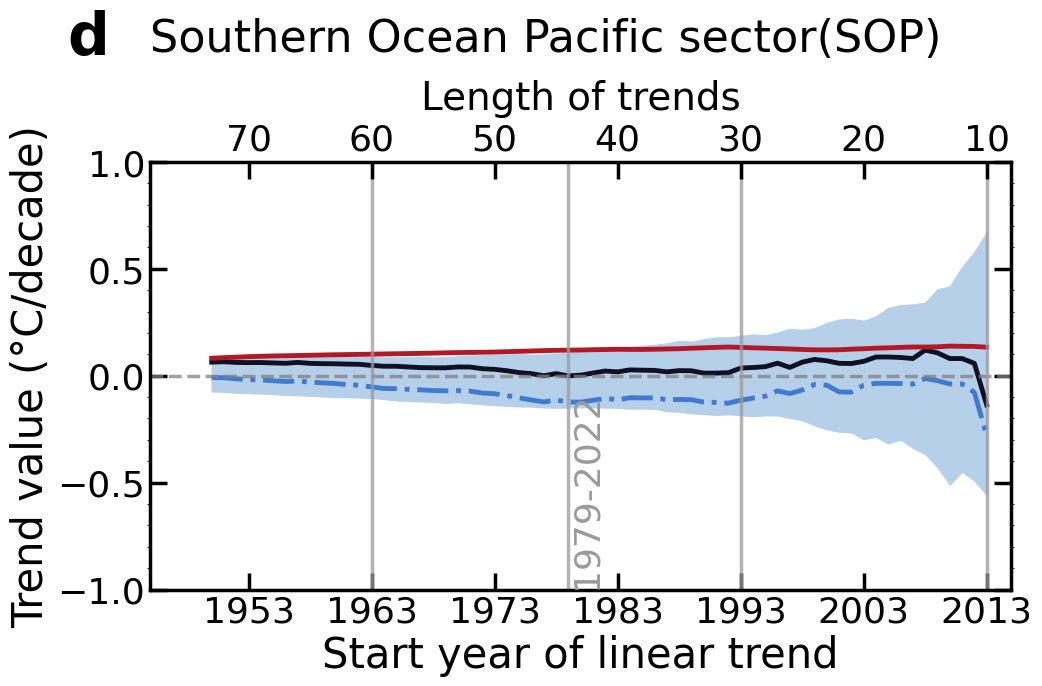

In [32]:
import seaborn as sns
from matplotlib.lines import Line2D

# sns.set_theme(style="whitegrid")
# Set the font dictionaries (for plot title and axis titles)
title_font = {'fontname': 'Arial', 'size': '20', 'color': 'black', 'weight': 'normal',
                'verticalalignment': 'bottom'}  # Bottom vertical alignment for more space
axis_font = {'fontname': 'Arial', 'size': '20'}

# Create the plot
fig = plt.figure(figsize=(25, 15))
gs = gridspec.GridSpec(2, 2, wspace=0.25, hspace=0.7)

ax1 = plt.subplot(gs[0, 0])
# ax2 = plt.subplot(gs[0, 1])
# ax3 = plt.subplot(gs[1, 0])
# ax4 = plt.subplot(gs[1, 1])

# define rgb colors for the outlines
# colors = [(32,120,180), #blue
#           (106,61,154), #purple
#           (173,23,88), #magenta
#           (255,127,0), #orange
#           (226,26,27),#red
#           (49,160,45) #green
#          ]
# colors_set = [(r / 255, g / 255, b / 255) for r, g, b in colors]
colors = ['#0F1023','#B11927', '#407BD0', '#B7D0EA']
line_widths = [5.5, 5.5, 5.5, 5.5, 1.5, 1.5, 1.5]
titles = ['Southern Ocean Pacific sector(SOP)']
linestyles = ['-', '-', '-.', ':']

vars = ['raw', 'forced', 'internal']
# We use a loop to simulate multiple lines for each category
for i, var in enumerate(vars):
    # Plot the forced trends for the EU region
    sns.lineplot(x=np.arange(1950,2014), y=trends_ds[var].values, color=colors[i], linestyle=linestyles[i], linewidth=3.5, ax=ax1)

ax1.fill_between(np.arange(1950,2014), SOP_unforced_lower.trend.values[::-1], SOP_unforced_upper.trend.values[::-1], color=colors[3])

ax1.set_xlim([1945, 2015])
ax1.set_ylim([-1.0, 1.0])
ax1.set_xticks([1953, 1963, 1973, 1983, 1993, 2003, 2013])
ax1.set_xticklabels(['1953', '1963', '1973', '1983', '1993', '2003', '2013'])
ax1_upper = ax1.twiny()
ax1_upper.invert_xaxis()
ax1_upper.set_xlim([78,8])
ax1_upper.set_xlabel('Length of trends', fontsize=28, labelpad=10)
ax1_upper.set_xticks([70, 60, 50, 40, 30, 20, 10])
ax1_upper.set_xticklabels(['70', '60', '50', '40', '30', '20', '10'])
ax1.spines['top'].set_linewidth(2.5)
ax1.spines['right'].set_linewidth(2.5)
ax1.spines['bottom'].set_linewidth(2.5)
ax1.spines['left'].set_linewidth(2.5)
ax1_upper.tick_params(axis='x', labelsize=26)
ax1_upper.tick_params(axis='x', which='major', length=12, width=2.5, direction='in')
ax1.axhline(y=0, color='grey', linestyle='--', linewidth=2.5, alpha=0.75)
ax1.set_ylabel('Trend value (°C/decade)', fontsize=30)
ax1.set_xlabel('Start year of linear trend', fontsize=30)
ax1.set_title(titles[0], loc='left',fontsize=32,pad=20)
ax1.tick_params(axis='x', which='major', length=12, labelsize=26, width=2.5, direction='in')
ax1.tick_params(axis='y', which='major', length=12, labelsize=26, width=2.5, direction='in')
ax1.axvline(x=2013, color='#999A9E', linestyle='-', linewidth=2.5, alpha=0.75)
ax1.axvline(x=1993, color='#999A9E', linestyle='-', linewidth=2.5, alpha=0.75)
ax1.axvline(x=1979, color='#999A9E', linestyle='-', linewidth=2.5, alpha=0.75)
ax1.axvline(x=1963, color='#999A9E', linestyle='-', linewidth=2.5, alpha=0.75)
ax1.text(1979.1, -0.96, '1979-2022', fontsize=26, rotation=90, color='#999A9E')
ax1.text(1940, 1.58, 'd', fontsize=42, ha='center', va='center', fontweight='bold')
# custom_lines = [Line2D([0], [0], color=colors[0], lw=3.5),
#                 Line2D([0], [0], color=colors[1], lw=3.5),
#                 Line2D([0], [0], color=colors[2], lw=3.5)]
# leg2 = ax1.legend(custom_lines, ['total', 'human forced', 'internal variability'], 
#                   loc='lower left', fontsize=26)
# ax1.add_artist(leg2)
plt.savefig('./SOP_trend_variations.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# # 3rd calculate the internal trend
# internal_temp_dict = {}
# internal_pvalue_dict = {}

# for i in range(len(variable_name)):
#     data_var = internal_dict[variable_name[i]]['tas']
    
#     slope, p_values = xr.apply_ufunc(
#         func_mk,
#         data_var,
#         input_core_dims=[["year"]],
#         output_core_dims=[[], []],
#         vectorize=True,
#         dask="parallelized",
#         output_dtypes=[float, float],
#         dask_gufunc_kwargs={'allow_rechunk': True}
#     )
#     internal_temp_dict[variable_name[i]] = slope
#     internal_pvalue_dict[variable_name[i]] = p_values

# internal_temp_annual_np = {}
# internal_pvalue_annual_np = {}

# for i in range(len(variable_name)):
#     internal_temp_annual_np[variable_name[i]] = internal_temp_dict[variable_name[i]].values
#     internal_pvalue_annual_np[variable_name[i]] = internal_pvalue_dict[variable_name[i]].values
    
# internal_temp_annual_da = {}
# internal_pvalue_annual_da = {}

# for interval, data in internal_temp_annual_np.items():
#     internal_temp_annual_da[interval] = xr.DataArray(data, dims=["lat", "lon"], coords={"lat": data_dict[interval].lat, "lon": data_dict[interval].lon})
# for interval, data in internal_pvalue_annual_np.items():
#     internal_pvalue_annual_da[interval] = xr.DataArray(data, dims=["lat", "lon"], coords={"lat": data_dict[interval].lat, "lon": data_dict[interval].lon})


### Plotting with the Robinson Projections

In [ ]:
# define an asymmetric colormap
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.colors import BoundaryNorm
import cartopy.util as cutil
import seaborn as sns
import matplotlib.colors as mcolors
import palettable

In [ ]:
# transform the trend data unit to degree per decade
for i in temp_annual_da.keys():
    temp_annual_da[i] = temp_annual_da[i] * 10

In [ ]:
# temp_annual_da.items()

In [ ]:
# check the min and max value of the trend
for i in temp_annual_da.keys():
    print(i, temp_annual_da[i].min().values, temp_annual_da[i].max().values)

In [ ]:
# # Define the GridSpec
# fig = plt.figure(figsize=(15, 10))
# gs = gridspec.GridSpec(2, 2, figure=fig, hspace=0.01, wspace=0.01)

# ax = fig.add_subplot(gs[0, 0], projection=ccrs.Robinson(180))
# temp_annual_da_with_cyclic, lon_cyclic = cutil.add_cyclic_point(temp_annual_da['35yr'], coord=lon)
# pvalue_annual_da_with_cyclic, _ = cutil.add_cyclic_point(pvalue_annual_da['35yr'], coord=lon)
# contour_obj = plot_temp_with_significance(temp_annual_da_with_cyclic, lat, lon_cyclic, pvalue_annual_da_with_cyclic,
#             GMST_p_values=None, levels=levels,extend='both', cmap='twilight_shifted',
#             title=" ", ax=ax, show_xticks=False, show_yticks=True)
# ax.set_title('Raw', fontsize=22, pad=10.0)

# ax1 = fig.add_subplot(gs[0, 1], projection=ccrs.Robinson(180))
# forced_temp_annual_da_with_cyclic, lon_cyclic = cutil.add_cyclic_point(forced_temp_annual_da['35yr'], coord=lon)
# forced_pvalue_annual_da_with_cyclic, _ = cutil.add_cyclic_point(forced_pvalue_annual_da['35yr'], coord=lon)
# contour_obj1 = plot_temp_with_significance(forced_temp_annual_da_with_cyclic, lat, lon_cyclic, forced_pvalue_annual_da_with_cyclic,
#             GMST_p_values=None, levels=levels,extend='both', cmap='twilight_shifted',
#             title=" ", ax=ax1, show_xticks=False, show_yticks=False)
# ax1.set_title('Forced wrt. MMEM', fontsize=22, pad=10.0)

# ax2 = fig.add_subplot(gs[1, 0], projection=ccrs.Robinson(180))
# internal_temp_annual_da_with_cyclic, lon_cyclic = cutil.add_cyclic_point(internal_temp_annual_da['35yr'], coord=lon)
# internal_pvalue_annual_da_with_cyclic, _ = cutil.add_cyclic_point(internal_pvalue_annual_da['35yr'], coord=lon)
# contour_obj2 = plot_temp_with_significance(internal_temp_annual_da_with_cyclic, lat, lon_cyclic, internal_pvalue_annual_da_with_cyclic,
#             GMST_p_values=None, levels=levels,extend='both', cmap='twilight_shifted',
#             title=" ", ax=ax2, show_xticks=True, show_yticks=True)

# ax2.set_title('Unforced wrt. MMEM', fontsize=22, pad=10.0)


# ax3 = fig.add_subplot(gs[1, 1], projection=ccrs.Robinson(180))
# MMEM_temp_annual_da_with_cyclic, lon_cyclic = cutil.add_cyclic_point(MMEM_temp_annual_da['35yr'], coord=lon)
# MMEM_pvalue_annual_da_with_cyclic, _ = cutil.add_cyclic_point(MMEM_pvalue_annual_da['35yr'], coord=lon)

# contour_obj3 = plot_temp_with_significance(MMEM_temp_annual_da_with_cyclic, lat, lon_cyclic, MMEM_pvalue_annual_da_with_cyclic,
#             GMST_p_values=None, levels=levels,extend='both', cmap='twilight_shifted',
#             title=" ", ax=ax3, show_xticks=True, show_yticks=False)
# ax3.set_title('MMEM', fontsize=22, pad=10.0)

# # add a line for the Southern Ocean region as the boundary (40S)
# # Southern Ocean box
# ax.plot([0, 360, 360, 0, 0], [-40, -40, -60, -60, -40],
# color='blue', linewidth=1.5, marker='.',
# transform=ccrs.PlateCarree())

# ax1.plot([0, 360, 360, 0, 0], [-40, -40, -60, -60, -40],
# color='blue', linewidth=1.5, marker='.',
# transform=ccrs.PlateCarree())

# ax2.plot([0, 360, 360, 0, 0], [-40, -40, -60, -60, -40],
# color='blue', linewidth=1.5, marker='.',
# transform=ccrs.PlateCarree())

# ax3.plot([0, 360, 360, 0, 0], [-40, -40, -60, -60, -40],
# color='blue', linewidth=1.5, marker='.',
# transform=ccrs.PlateCarree())

# # # EU box
# # ax.plot([45%360, 120%360, 120%360, 45%360, 45%360], [45, 45, 60, 60, 45],
# # color='blue', linewidth=1.5, marker='.',
# # transform=ccrs.PlateCarree())

# # # NA box
# # ax.plot([-120%360, -70%360, -70%360, -120%360, -120%360], [45, 45, 70, 70, 45],
# # color='blue', linewidth=1.5, marker='.',
# # transform=ccrs.PlateCarree())
        
# # add the title for each row
# # for i, period in enumerate(periods):
# #     axes[i,0].text(0.125, 1.1, titles_rows[i], va='bottom', ha='center', rotation='horizontal', fontsize=16, 
# #                     weight='bold',transform=axes[i, 0].transAxes)

# # Add horizontal colorbars
# cbar_ax = fig.add_axes([0.25, 0.10, 0.5, 0.015])
# cbar = plt.colorbar(contour_obj, cax=cbar_ax, orientation='horizontal', extend=extend)
# fig.text(0.5, 0.04,'Annual SAT trend ($^\circ$C/35yr)',fontsize=18, ha='center', va='bottom')
# cbar.ax.tick_params(labelsize=18)

# plt.tight_layout()
# fig.savefig('HadCRUT5-OLS-trend-pattern-separation-1979-2013.png', dpi=300, bbox_inches='tight')
# plt.show()

In [ ]:
# len(temp_annual_da.keys())

### Output the figure to the PDF files

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

lat = temp_annual_da['1950-2022'].lat
lon = temp_annual_da['1950-2022'].lon
levels = np.arange(-0.5, 0.55, 0.05)
extend = 'both'

# Define the number of plots per page
num_plots_per_page = 4
num_subplots_x = 2  # Number of subplots in the x direction (columns)
num_subplots_y = 2  # Number of subplots in the y direction (rows)

# Define the dimensions of the figure for each page
figsize_x = 20
figsize_y = 12

cmap = mcolors.ListedColormap(palettable.cmocean.diverging.Balance_20.mpl_colors)
# # Create a PDF pages object
# with PdfPages('./SAT_temp_figures.pdf') as pdf:
#     # Create a new figure for adding subplots
#     fig = plt.figure(figsize=(figsize_x, figsize_y))
#     axes = np.empty((num_subplots_y, num_subplots_x), dtype=object)
#     for i in range(num_subplots_y):
#         for j in range(num_subplots_x):
#             axes[i, j] = fig.add_subplot(num_subplots_y, num_subplots_x, i * num_subplots_x + j + 1, projection=ccrs.Robinson(180))
        
#             # Counter for the data items
#             count = 0

#             for interval,data in temp_annual_da.items():
#             # Determine the position of the current plot
#                 ix = count % num_subplots_x
#                 iy = count // num_subplots_x % num_subplots_y

#                 # Plot the data on the appropriate subplot
#                 ax = axes[iy, ix]
#                 temp_annual_da_with_cyclic, lon_cyclic = cutil.add_cyclic_point(data, coord=lon)
#                 pvalue_annual_da_with_cyclic, _ = cutil.add_cyclic_point(pvalue_annual_da[interval], coord=lon)
                
#                 contour_obj = plot_temp_with_significance(temp_annual_da_with_cyclic, lat, lon_cyclic, pvalue_annual_da_with_cyclic,
#                     GMST_p_values=None, levels=levels,extend='both', cmap='twilight_shifted',
#                     title=" ", ax=ax, show_xticks=False, show_yticks=False)
#                 ax.set_title(f"Trend for {interval}")
            
#             count += 1

#             # If we've reached the end of the page, save and start a new figure
#             if (count % num_plots_per_page == 0) or (count == len(temp_annual_da.keys())):
#                 pdf.savefig(fig)
#                 plt.close(fig)  # Close the figure to free memory
                
#                 # If there's more data to plot, create a new figure
#                 if count != len(temp_annual_da.keys()):
#                     fig, axes = plt.subplots(num_subplots_y, num_subplots_x, figsize=(figsize_x, figsize_y))
#                     fig.subplots_adjust(hspace=0.4, wspace=0.4)
#             # add colorbar for each page
#             cbar_ax = fig.add_axes([0.25, 0.10, 0.5, 0.015])
#             cbar = plt.colorbar(contour_obj, cax=cbar_ax, orientation='horizontal', extend=extend)
#             fig.text(0.5, 0.04,'Annual SAT trend ($^\circ$C/decade)',fontsize=18, ha='center', va='bottom')
#             cbar.ax.tick_params(labelsize=18)
#             pdf.savefig(fig)
#             plt.close(fig)

In [ ]:
start_year = 1950
end_year = 2022
min_length = 10
# num_plots_per_page = 4
# num_subplots_x = 2
# num_subplots_y = 2
# figsize_x = 15
# figsize_y = 8.5

with PdfPages('./Raw_SAT_temp_figures_check_SEP.pdf') as pdf:
    for start_page in range(0, len(trend_annual_da.keys()), num_plots_per_page):
        fig, axes = plt.subplots(num_subplots_y, num_subplots_x, figsize=(figsize_x, figsize_y),
                                 subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})
        fig.subplots_adjust(hspace=0.4, wspace=0.4)
        
        for i in range(num_plots_per_page):
            idx = start_page + i
            if idx >= len(trend_annual_da.keys()):
                break
            interval = list(trend_annual_da.keys())[idx]
            data = trend_annual_da[interval]
            
            ix = i % num_subplots_x
            iy = i // num_subplots_x
            
            ax = axes[iy, ix]
         
            # Add cyclic point to data
            data_with_cyclic, lon_cyclic = cutil.add_cyclic_point(data, coord=lon)
            p_values_with_cyclic, _ = cutil.add_cyclic_point(pvalue_annual_da[interval], coord=lon)
            
            # Plotting the data with significance
            contour_obj = plot_trend_with_significance(data_with_cyclic, lat, lon_cyclic, p_values_with_cyclic,
                                                        levels=levels, extend=extend, cmap=cmap,
                                                        title=" ", ax=ax, show_xticks=False, show_yticks=False)
            ax.set_title(f"Trend for {interval}", fontsize=18)
            ax.plot([200%360, 280%360, 280%360, 250%360, 200%360], [0, 0, -25, -25, 0],
            color='tab:blue', linewidth=2.0,
            transform=ccrs.PlateCarree())
        # Add colorbar for each page
        cbar_ax = fig.add_axes([0.25, 0.05, 0.5, 0.02])
        cbar = plt.colorbar(contour_obj, cax=cbar_ax, orientation='horizontal', extend=extend)
        cbar.set_label('Annual SAT trend (°C per decade)', fontsize=16)
        
        # Save the page
        pdf.savefig(fig)
        plt.close(fig)

In [ ]:
client.close()
scluster.close()